In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import trapezoid, quad
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# Q.1 Consider a normal state density of states $\nu_0 (E) = \nu_0 = const$, on top of which a superconducting gap forms. Calculate, for an isotropic s-wave like order parameter $\Delta = \Delta_0$,

### (a) the resulting density of states $ \nu_s (E,T) = \text{Re}\left(\frac{|E|}{E^2 - \Delta(T)^2}\right)$ for different temperatures $T$ (you may want to use the approximation $ \Delta (T)=\Delta (0) \text{Re}(\tanh(\alpha \frac{\pi}{2} \sqrt(\frac{Tc}{T} - 1))$ with $\alpha=1.138$ and $ \Delta(0) = 1.764 k_B T_c $ for the temperature dependence of the gap in the superconducting state).

#### Constants

In [2]:
alpha = 1.138
kB = 1.380649E-23
kBv = 8.617333E-5     # eV instead of J
T0 = 20
Tc = 80
meV_J = 1.6*10E-22

#### Interactive function

In [3]:
def intrdos_s(func, Tmin, Tmax):
    %matplotlib inline
    interactive_plot = interactive(func, T = (Tmin,Tmax,5))
    output = interactive_plot.children[-1]
    output.layout.height = '500px'
    return interactive_plot

#### Function

##### Base

In [4]:
def DeltaT(T, Tc = Tc):
    D0 = 1.764 * kBv * Tc
    if T == 0:
        return D0
    else:
        arg = alpha * np.pi/2 * np.sqrt(Tc/T - 1, dtype = np.complex128)
        DT = D0 * np.real(np.tanh(arg))
        return DT

def dos_s(E_meV, T = T0, Tc = Tc):
    E_eV = E_meV*10**(-3)
    nu = np.real(np.abs(E_eV) / np.sqrt((E_eV)**2 - (DeltaT(T, Tc))**2, dtype = np.complex128))
    return nu
Evals = np.linspace(-50,50,256) # in meV

##### Multiple temperatures

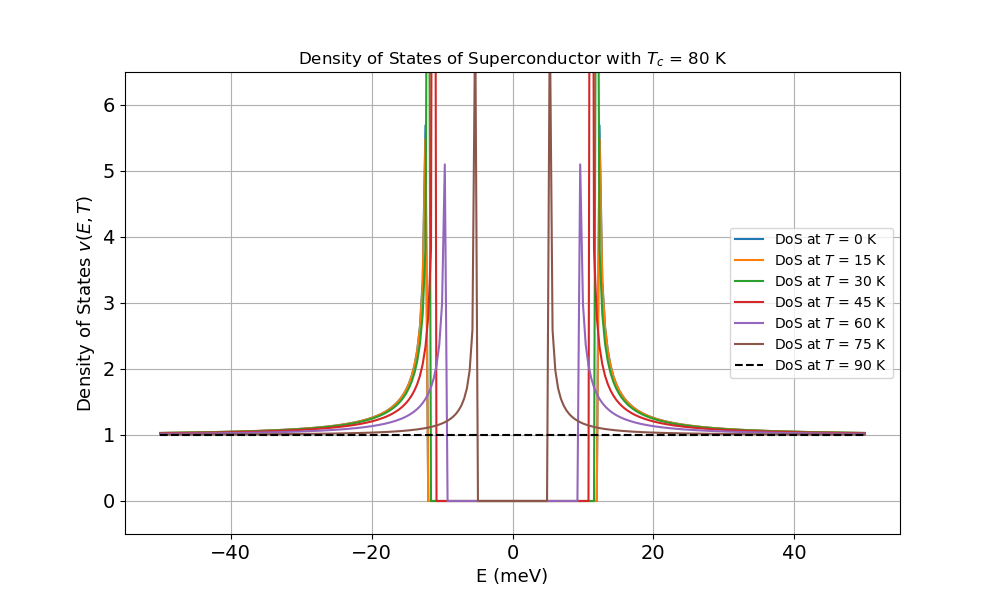

In [5]:
def dos_s_rep(Temps):
    %matplotlib widget
    fig, ax = plt.subplots(figsize = (10,6))
    for T in Temps:
        if T > Tc:
            ax.plot(Evals, dos_s(Evals, T), ls = '--', c = 'k', label = 'DoS at $T$ = ' + str(T) + ' K')
        else:
            ax.plot(Evals, dos_s(Evals, T), label = 'DoS at $T$ = ' + str(T) + ' K')
    ax.set_title('Density of States of Superconductor with $T_c$ = ' + str(Tc) + ' K')
    ax.set_xlabel('E (meV)', fontsize = 13)
    ax.set_ylabel('Density of States $v(E,T)$', fontsize = 13)
    ax.set_ylim(-0.5,6.5)
    ax.tick_params(labelsize = 14)
    ax.legend(loc = 'center right')
    ax.grid()
    plt.show()
Tarray = np.arange(0,91,15)
dos_s_rep(Tarray)

##### Interactive temperature

In [9]:
def dos_s_intr(T):
    %matplotlib widget
    dos1 = dos_s(Evals, T)
    peaks = find_peaks(dos1)[0]
    E_peaks = Evals[peaks]
    Delta = (np.abs(E_peaks[0])+np.abs(E_peaks[1]))/2
    fig, ax = plt.subplots(figsize = (7,5))
    ax.plot(Evals, dos1)
    if T < Tc:
        ax.arrow(E_peaks[0], 2.5, np.abs(E_peaks[1]-E_peaks[0]), 0, color='red', head_length = 0.1, head_width = 0.1, length_includes_head = True, zorder = 9)
        ax.arrow(E_peaks[1], 2.5, -np.abs(E_peaks[1]-E_peaks[0]), 0, color='red', head_length = 0.1, head_width = 0.1, length_includes_head = True, zorder = 9)
        ax.annotate('$2\Delta$', (-0.2, 2.6))
        print('Δ = ' + str(Delta))
    ax.set_title('Density of States of Superconductor with $T_c$ = ' + str(Tc) + ' K at $T$ = ' + str(T) + ' K')
    ax.set_xlabel('E (meV)', fontsize = 13)
    ax.set_ylabel('Density of States $\\nu (E,T)$', fontsize = 13)
    ax.set_ylim(0,5)
    ax.grid()
    plt.show()
intrdos_s(dos_s_intr,5,100)
# print('If executed, this function lets you visualise how the DoS for an s-wave superconductpr varies with temperature')

interactive(children=(IntSlider(value=50, description='T', min=5, step=5), Output(layout=Layout(height='500px'…

### (b) the resulting tunneling conductance one would measure with this density of states against a normal metal electrode, using $g(V,T)=-\int_{-\infty}^{\infty} \nu_s (E,T)n'(E-eV,T)\,dE)$ where $n'(E,T)=\frac{\partial}{\partial E}n(E,T)$ ($n(E, T)$ is the Fermi function, i.e. $n(E, T)=\frac{1}{e^{E/k_B T} +1}$. Discuss your findings

#### Functions

In [247]:
def Betav(T):
    return 1/(kBv*T)                                      # in eV^-1

def Eintgt(T, kbts = 10**3):                                      # kbts gives the range for the x-axis
    if T != 0:
        Bv = Betav(T)                                                 # ~ 10^4
        step = (1/(100*Bv))                                           # ~ 10^(-6) eV
        E_array = (np.arange(-kbts/Bv,kbts/Bv+step, step))*10**(3)    # this should have 200*kbts+1 elements including 0. In meV
        dE = step * 10**(3)                                           # in meV    
        return [E_array , dE]
    else:
        t = 0.5
        Bv = Betav(t)                                                 # ~ 10^4
        step = (1/(100*Bv))                                           # ~ 10^(-6) eV
        E_array = (np.arange(-kbts/Bv,kbts/Bv+step, step))*10**(3)    # this should have 200*kbts+1 elements including 0. In meV
        dE = step * 10**(3)                                           # in meV    
        return [E_array , dE]

def fermi(E_meV,T):
    E_eV = E_meV*10**(-3)                                    # now in eV
    Bv = Betav(T)                        
    return 1/(np.exp(E_eV*Bv)+1)

def fermiprime(E_meV,T):
    func1 = fermi(E_meV,T)
    func2 = 1 - fermi(E_meV,T)
    return - Betav(T) * func1 * func2

def tun_intgd_s(E_meV,eV_meV,T):                             # E and eV should both be in meV
    mu_s = dos_s(E_meV, T)
    Ediff_meV = E_meV - eV_meV # still in meV
    nprime = fermiprime(Ediff_meV, T)
    return mu_s * nprime

def gs(V_mV, T):                # V in mV
    eV_meV = V_mV              # 'multiplied by e=1 in eV' now in meV
    E = Eintgt(T)
    Energies = E[0]            # in meV
    dE = E[1]                  # in meV
    I = np.trapz(tun_intgd_s(Energies,eV_meV,T), Energies, dE)
    return -I*10**(-3)

#### Integrand plots (many voltages) s-wave

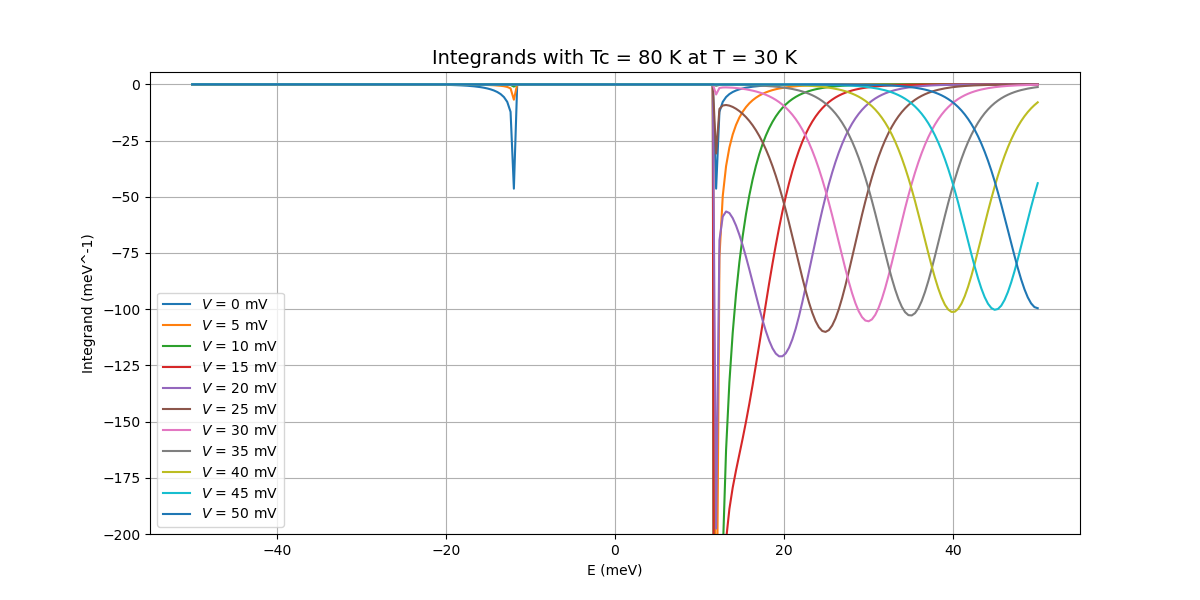

In [306]:
Vs = np.arange(0,51,5)
Tv = 30
fig, ax = plt.subplots(figsize = (12,6))
#ax.plot(Evals, fermi(Evals, 40), label = 'Fermi function')
#ax.plot(Evals, fermiprime(Evals, 40), label = 'Fermi prime')
#ax.plot(Evals, dos(Evals, 40), label = 'Density of States')
#ax.plot(Evals, dos(Evals, 40)*fermiprime(Evals, 40), label = 'Product')
for V in Vs:
    ax.plot(Evals, tun_intgd_s(Evals, V, Tv), label = '$V$ = ' + str(V) + ' mV')
ax.set_title('Integrands with Tc = ' + str(Tc) + ' K at T = ' + str(Tv) + ' K', fontsize = 14)
ax.set_xlabel('E (meV)')
ax.set_ylabel('Integrand (meV^-1)')
ax.set_ylim(-200, 5.5)
ax.grid()
ax.legend()
plt.show()

#### Integrand interactive function

In [249]:
def intrintgd_s(func, eV_meVmin, eV_meVmax, Tmin, Tmax):
    %matplotlib inline
    interactive_plot = interactive(func, eV_meV = (eV_meVmin,eV_meVmax,1), T = (Tmin,Tmax,5))
    output = interactive_plot.children[-1]
    output.layout.height = '500px'
    return interactive_plot

In [271]:
def intgd_s_intr(eV_meV, T):
    %matplotlib widget
    # E = Eintgt/meV_J
    tin = tun_intgd_s(Evals, eV_meV, T) # E and eV in meV
    fig, ax = plt.subplots(figsize = (8,5))
    ax.plot(Evals, tin)
    ax.set_title('Integrand with Tc = ' + str(Tc) + ' K at T = ' + str(T) + ' K and ' + str(eV_meV) + ' meV bias')
    ax.set_xlabel('E (meV)', fontsize = 13)
    ax.set_ylabel('Units of $k_B T$', fontsize = 13)
    # ax.set_ylim(0,5)
    ax.grid()
    plt.show()
#intrintgd_s(intgd_s_intr,-60,60,5,100)
print('If executed, this function lets you visualise how the integrand varies with temperature and voltage.')

If executed, this function lets you visualise how the integrand varies with temperature and voltage.


#### Tunnelling Conductance s-wave

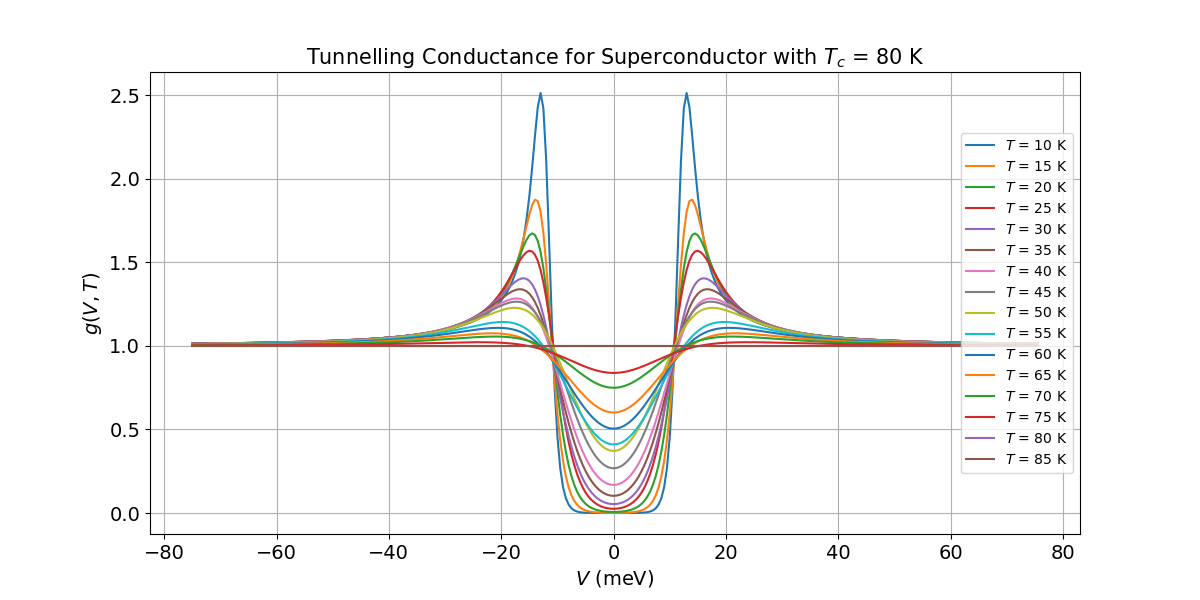

In [307]:
Vvals = np.arange(-75,75+1,0.5)           # mV
Ts = np.arange(10,86,5)
T = [30]
fig, ax = plt.subplots(figsize = (12,6))
for T in Ts:
    g_array = []
    for V in Vvals:
        g1 = gs(V,T)
        g_array = np.append(g_array, g1)
    ax.plot(Vvals, g_array, label = '$T$ = ' + str(T) + ' K')
ax.set_title('Tunnelling Conductance for Superconductor with $T_c$ = ' + str(Tc) + ' K', fontsize = 15)
ax.set_xlabel('$V$ (meV)', fontsize = 14)
ax.set_ylabel('$g(V,T)$',  fontsize = 14)
ax.tick_params(labelsize = 14)
ax.grid()
ax.legend(loc = 'center right')
plt.show()

#### Discussion

In [252]:
print('We have a tunnelling conductance symmetric about V = 0. This corresponds with what we would expect to measure with an STM applying a varying voltage to the tip. The shape informs us that we do not easily pick up electrons at the band gap voltages since these are in Cooper pairs in the superconducing condensate and "breaking" this state requires more energy than provided by the voltage.')

We have a tunnelling conductance symmetric about V = 0. This corresponds with what we would expect to measure with an STM applying a varying voltage to the tip. The shape informs us that we do not easily pick up electrons at the band gap voltages since these are in Cooper pairs in the superconducing condensate and "breaking" this state requires more energy than provided by the voltage.


### c) Discuss any differences between the two, in particular looking at the temperature dependence. How can one extract the gap size from measured data? Demonstrate this for a method of your choice, and show the temperature dependence of that measure.

#### Discussion

In [253]:
print('The width of the gap seems to vary more with temperature than in the second one. As well, the plots seem to shoot up towards very large values at the edges of the gap in the first one while in the second one this is smoothed out. Also, the edges are vertical and sharp in the first one while in the second one they are smooth and gradual. Additionally, in the first one, for all temperatures below Tc we measure 0 in the gap and at Tc and above the value jumps discontinuously to 1 while in the second one the gap floor gradually moves from 0 to the flat 0.6. The gap size can be extracted from the measured data (e.g. conductance with an STM scan) by performing a Fourier analysis such that the convolution is turned into a product and we can eliminate the effect of n-dash by simply dividing the data by its FT. Inverse transforming the remainder should give us the density of states from which we can obtain the gap as a function of temperature by measuring the peak-to-peak distance and dividing it by 2 at different temperatures. Here, I will measure the gap by measuring the peak-to-peak distances for the values obtained in a) for different temperatures.')

The width of the gap seems to vary more with temperature than in the second one. As well, the plots seem to shoot up towards very large values at the edges of the gap in the first one while in the second one this is smoothed out. Also, the edges are vertical and sharp in the first one while in the second one they are smooth and gradual. Additionally, in the first one, for all temperatures below Tc we measure 0 in the gap and at Tc and above the value jumps discontinuously to 1 while in the second one the gap floor gradually moves from 0 to the flat 0.6. The gap size can be extracted from the measured data (e.g. conductance with an STM scan) by performing a Fourier analysis such that the convolution is turned into a product and we can eliminate the effect of n-dash by simply dividing the data by its FT. Inverse transforming the remainder should give us the density of states from which we can obtain the gap as a function of temperature by measuring the peak-to-peak distance and dividing 

#### Finding peaks

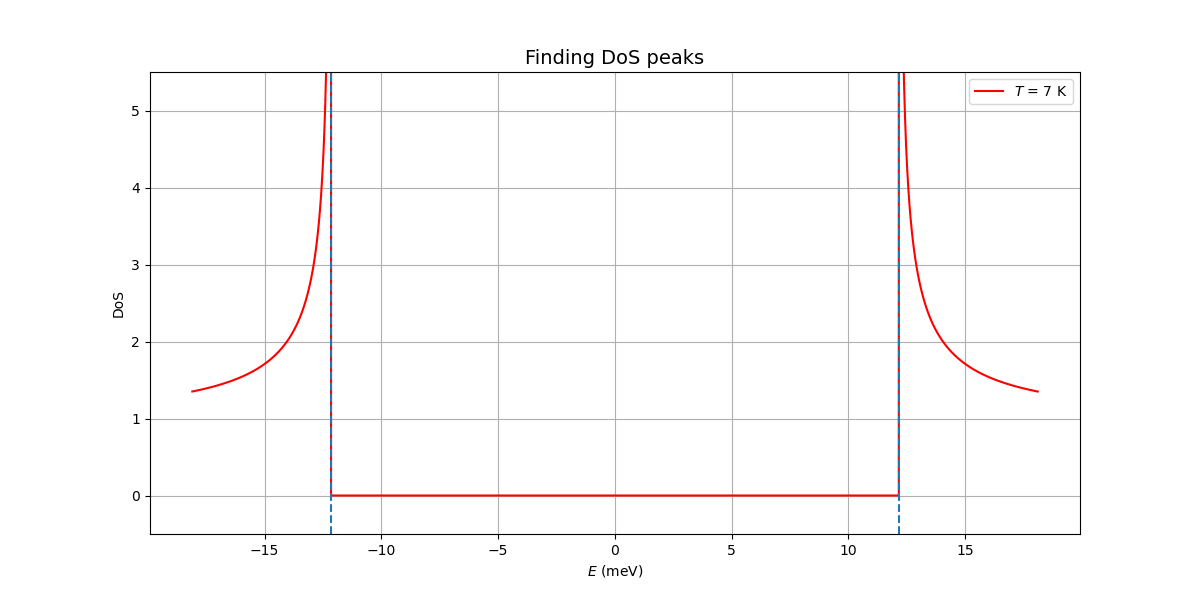

[ 984 5016]


In [272]:
T1 = 7
E = Eintgt(T1,30)[0]
peaks = find_peaks(dos_s(E, T1), height = 1.1)[0]
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(E, dos_s(E, T1), label = '$T$ = ' + str(T1) + ' K', c = 'r')
for p in peaks:
    ax.axvline(E[p],0,1,ls='--')
ax.set_title('Finding DoS peaks', fontsize = 14)
ax.set_xlabel('$E$ (meV)')
ax.set_ylabel('DoS')
ax.set_ylim(-0.5,5.5)
ax.grid()
ax.legend()
plt.show()
if T1<Tc:
    print(peaks)

#### Plotting $\Delta(T)$

In [255]:
def Delta(Tarray):
    gaps = []
    for T in Tarray:
        E = (Eintgt(T)[0])
        peaks = find_peaks(dos_s(E, T))[0]
        E_peaks = E[peaks]
        gap = (np.abs(E_peaks[-1]) + np.abs(E_peaks[0]))/2
        gaps = np.append(gaps, gap)
    return gaps

def BCS(T, Tc=Tc):
    bcs = []
    for t in T:
        bcsi = (DeltaT(t)) * 10**3
        bcs = np.append(bcs, bcsi)
    return bcs
Tgaps = np.arange(0, Tc, 0.5)
dlt = Delta(Tgaps)

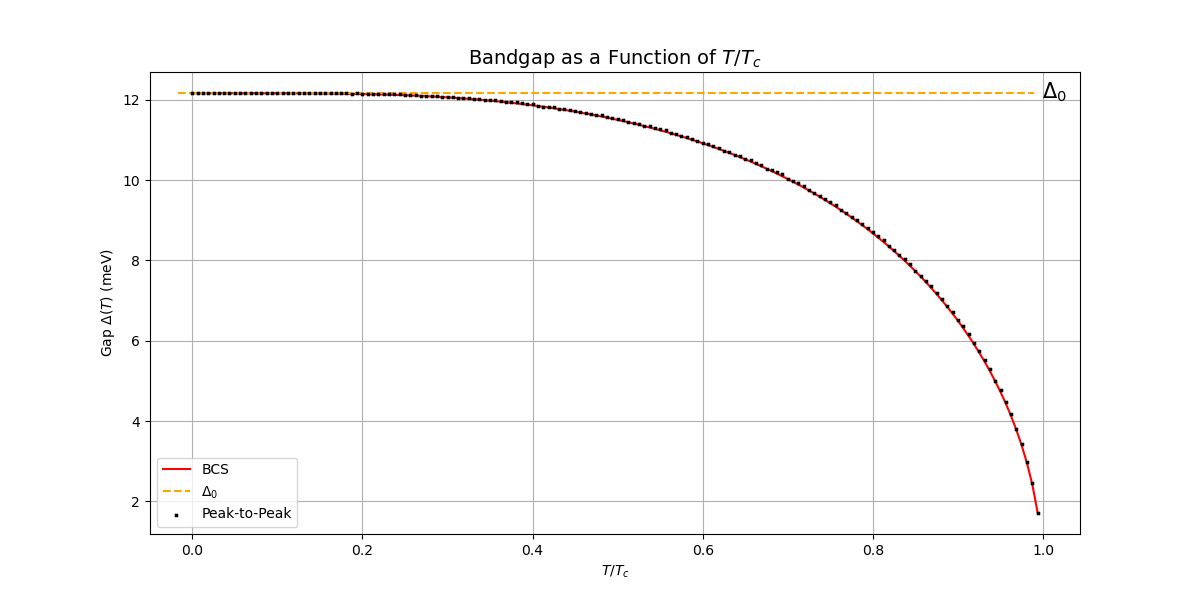

As can be seen, measuring the peak-to-peak values (and halving) gives similar measurements to those predicted by BCS theory showing that this is the appropriate method for measuring the bandgap.


In [273]:
D0 = DeltaT(0)
fig, ax = plt.subplots(figsize = (12,6))
ax.scatter(Tgaps/Tc, dlt, marker = 'x', s = 4, c = 'k', zorder = 9, label = 'Peak-to-Peak')
ax.plot(Tgaps/Tc, BCS(Tgaps), label = 'BCS', c = 'r')
ax.set_title('Bandgap as a Function of $T/T_c$', fontsize = 14)
ax.set_xlabel('$T/T_c$')
ax.set_ylabel('Gap $\Delta(T)$ (meV)')
ax.axhline(D0*10**3, 0.03, 0.95, ls = '--', c = 'orange', label = '$\Delta_0$')
ax.annotate('$\Delta_0$', (0.999, D0*10**3 - 0.14), size = 15)
ax.grid()
ax.legend()
plt.show()
print('As can be seen, measuring the peak-to-peak values (and halving) gives similar measurements to those predicted by BCS theory showing that this is the appropriate method for measuring the bandgap.')

### d) Calculate the electronic contribution to the specific heat for an s-wave superconductor. Use $C_s(T)=2\int_{-\infty}^{\infty} \nu_s (E,T)n'(E-eV,T)*\left(\frac{d\Delta^2(T)}{dT}-2E^2/T\right),dE)$. Compare this to the electronic contribution for a normal metal, $C_e=\gamma T$, which you can calculate from the same equation for $T>T_c$.

#### Functions

In [274]:
def sech2(x):
    return 1/(np.cosh(x))**2
  
def dd2dt(T, Tc=Tc):
    D0 = DeltaT(0)
    arg = alpha * np.pi/2 * np.sqrt(Tc/T - 1, dtype = np.complex128)
    der = - alpha * D0 * np.pi/4 * Tc * np.real((sech2(arg) / (np.sqrt(Tc/T - 1, dtype = np.complex128) * T**2)))
    return 2 * DeltaT(T) * der 
    
def cintgd(E_meV,T):
    E_eV = E_meV*10**(-3)
    nu_s = dos(E_meV,T)
    ndash = fermiprime(E_meV,T)
    intgd = nu_s * ndash * (dd2dt(T) - 2*E_eV**2/T)
    return intgd

def C(T):
    I = quad(cintgd, -np.inf, np.inf, args = (T))
    return 2*I[0]

#### Specific heat

In [275]:
Tcaps = np.arange(5, 141, 0.1)
  
Cvals = []
for T in Tcaps:
    c = C(T)
    Cvals = np.append(Cvals, c)
    
def Ce_fit(T, gamma):
    return gamma * T

gamma = curve_fit(Ce_fit, Tcaps[Tcaps>Tc], Cvals[Tcaps>Tc])[0][0]

Ce = Ce_fit(Tcaps, gamma)

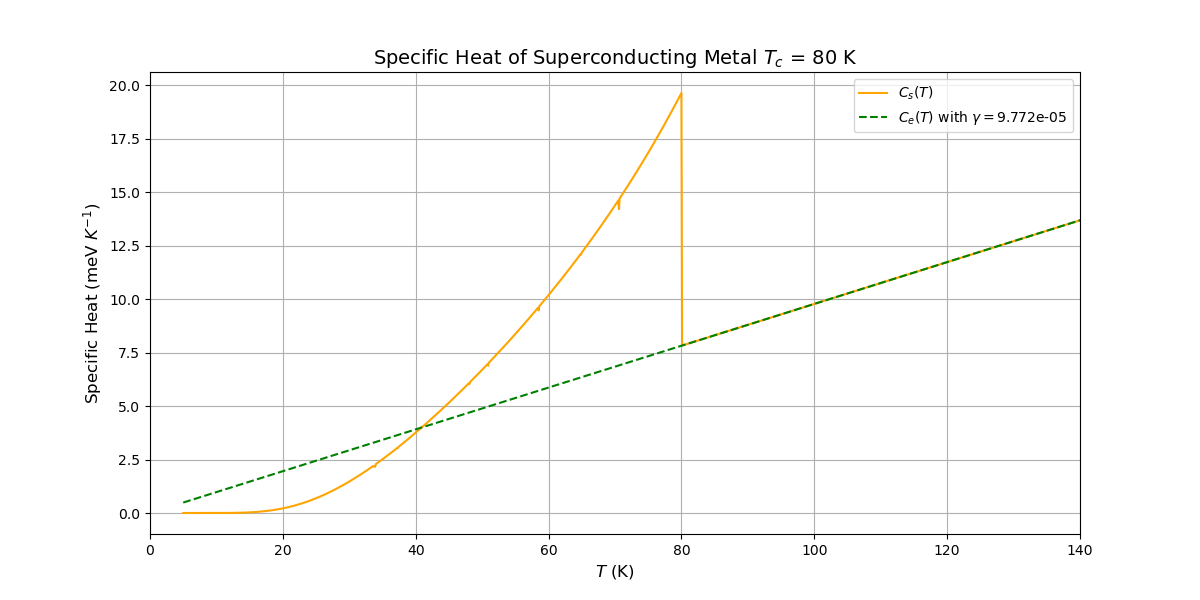

In [276]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(Tcaps, Cvals*1000, c = 'orange', label = '$C_s(T)$')
ax.plot(Tcaps, Ce*1000, c = 'green', ls = '--', label = '$C_e(T)$ with $\gamma = $' + str('{:.3e}'.format(gamma)))
ax.set_title('Specific Heat of Superconducting Metal $T_c$ = ' + str(Tc) + ' K', fontsize = 14)
ax.set_xlabel('$T$ (K)', fontsize = 12)
ax.set_ylabel('Specific Heat (meV ${K}^{-1}$)', fontsize = 12)
ax.grid()
ax.set_xlim(0,140)
ax.legend()
plt.show()

# Q.2 Having seen how the gap of a superconductor changes with temperature and affect macroscopic properties, let us have a look at how this changes for a different superconducting order parameters.

### (a) Calculate the density of states for a d-wave superconductor, where $\Delta(\theta) = \Delta_0 cos(2\theta)$. Note that this will entail an additional integration (i.e. $\nu_s(E) = \frac{1}{2 \pi} \int_{0}^{2 \pi} \text{Re} \left(\frac{|E|}{E^2 - \Delta(\theta)^2}\right)$. For a zero temperature calculation, you can use $\Delta_0 = \Delta(0)$ as defined in the first problem, for finite temperature calculations $\Delta_0 = \Delta(T)$. (strictly speaking, we would have to use a different value for $\frac{\Delta}{k_B T_c}$ here, but we will ignore that detail).

#### Functions

In [260]:
def DeltaTheta(Theta, T = 0, Tc = Tc):
    D = DeltaT(T, Tc)
    return D * np.cos(2 * Theta)

def intdos_d(Theta, E_meV, T, Tc = Tc):
    D = DeltaTheta(Theta, T, Tc)
    E_eV = E_meV * 10**(-3)
    return np.real(np.abs(E_eV)/np.sqrt(E_eV**2 - D**2, dtype = np.complex128))

def dos_d(E_meV_array, T = 0, Tc = Tc):
    prefactor = 1/(2*np.pi)
    Thetas = np.arange(0, 2*np.pi, 0.00001)
    Integral = []  
    for E in E_meV_array:
        I = 1/(2*np.pi)*np.trapz(intdos_d(Thetas,E,T,Tc), Thetas, 0.00001)
        Integral = np.append(Integral, I)
    return Integral

def dos_dsingE(E_meV, T = 0, Tc = Tc):
    prefactor = 1/(2*np.pi)
    Thetas = np.arange(0, 2*np.pi, 0.00001)
    I = 1/(2*np.pi)*np.trapz(intdos_d(Thetas,E_meV,T,Tc), Thetas, 0.00001)
    return I

#### Visualising functions

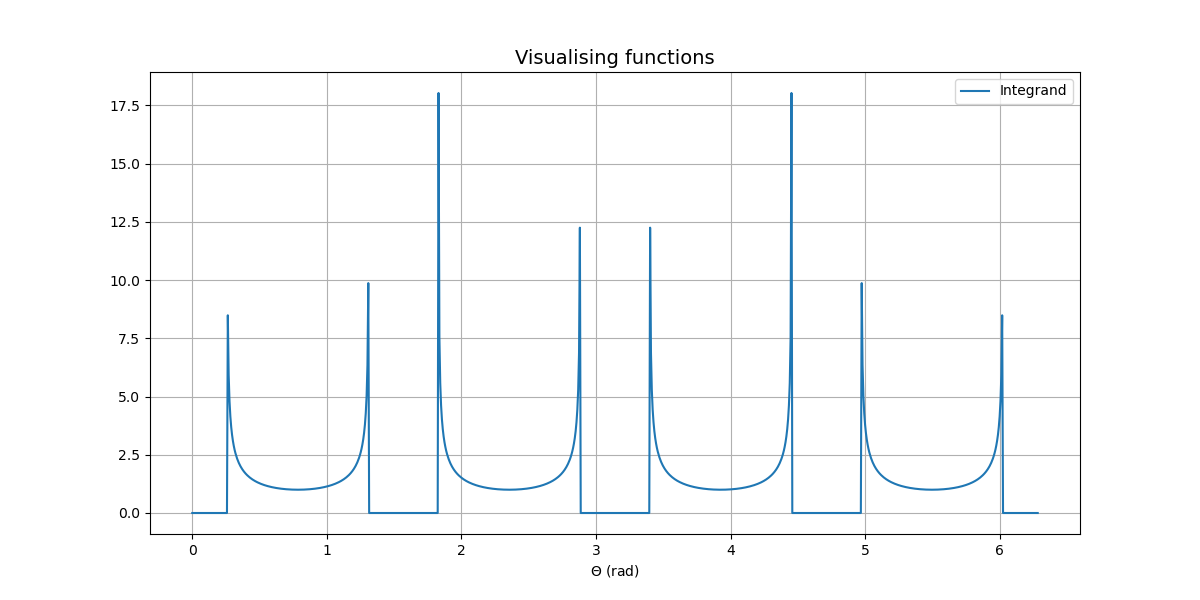

In [277]:
Thetas = np.linspace(0, 2*np.pi, 1000)
integrand = []
for th in Thetas:
    i = intdos_d(th, 10, 40)
    integrand = np.append(integrand, i)

fig, ax = plt.subplots(figsize = (12,6))
ax.plot(Thetas, integrand, label = 'Integrand')
ax.set_title('Visualising functions', fontsize = 14)
ax.set_xlabel('$\Theta$ (rad)')
#ax.set_ylim(-200, 5.5)
ax.grid()
ax.legend()
plt.show()

#### Density of states

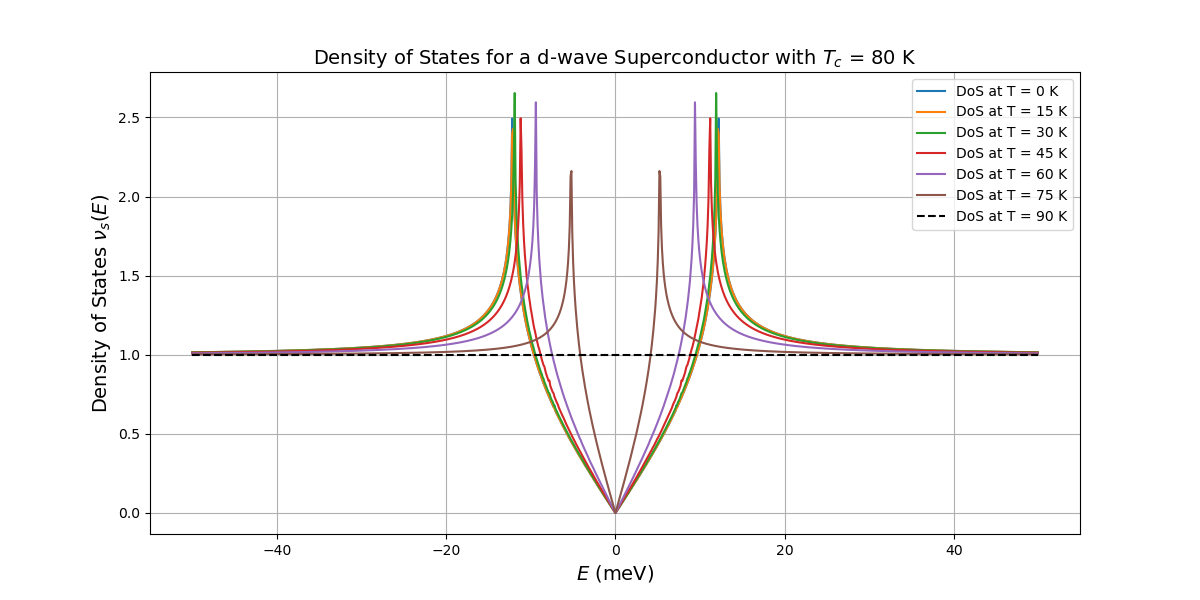

In [303]:
Evs = np.arange(-50,50,0.1) # in meV
Temps = np.arange(0,91,15)

fig, ax = plt.subplots(figsize = (12,6))
for T in Temps:
    if T > Tc:
        ax.plot(Evs, dos_d(Evs, T), ls = '--', c = 'k', label = 'DoS at T = ' + str(T) + ' K')
    else:    
        ax.plot(Evs, dos_d(Evs, T), label = 'DoS at T = ' + str(T) + ' K')
ax.set_title('Density of States for a d-wave Superconductor with $T_c$ = ' + str(Tc) + ' K', fontsize = 14)
ax.set_xlabel('$E$ (meV)', fontsize = 14)
ax.set_ylabel('Density of States $\\nu_s(E)$', fontsize = 14)
ax.grid()
ax.legend()
plt.show()

### (b) Discuss what the differences are between this case and the s-wave case. What measurements could you do to distinguish between the two? What temperatures would you need to discriminate between the two? Discuss this by comparing a measurable quantity for the two order parameters, and show a graph that shows the differences.

#### Discusion

In [279]:
print('For the d-wave case, the DoS does not have a gap as sharp and pronounced as the one in the s-wave case. We see that instead of a flat line at zero we get a smoother curve approaching zero only at E = 0. The reason for this differences is the angle dependence of Delta(T, Theta). As this quantity is larger at smaller T, its effect is most pronounced at low temperatures. As T becomes large, the order parameter Delta (and thus the gap) becomes small so the s-wave and d-wave case become less discernible. Tunneling condeuctance at low temperatures could therefore allow us to discern between these two superconductor types.')

For the d-wave case, the DoS does not have a gap as sharp and pronounced as the one in the s-wave case. We see that instead of a flat line at zero we get a smoother curve approaching zero only at E = 0. The reason for this differences is the angle dependence of Delta(T, Theta). As this quantity is larger at smaller T, its effect is most pronounced at low temperatures. As T becomes large, the order parameter Delta (and thus the gap) becomes small so the s-wave and d-wave case become less discernible. Tunneling condeuctance at low temperatures could therefore allow us to discern between these two superconductor types.


#### Functions

In [280]:
def tun_intgd_d(E_meV_array, eV_meV, T):                                # E and eV should both be in meV
    nu_d = dos_d(E_meV_array, T)
    Ediff_meV_array = E_meV_array - eV_meV                                        # still in meV
    nprime = fermiprime(Ediff_meV_array, T)
    return nu_d * nprime

def gd(V_mV, T):                # V in mV
    eV_meV = V_mV              # 'multiplied by e=1 in eV' now in meV
    E = Eintgt(T)
    Energies = E[0]            # in meV
    dE = E[1]                  # in meV
    I = np.trapz(tun_intgd_d2(Energies,eV_meV,T), Energies, dE)
    return -I*10**(-3)

#### Integrand interactive function

In [281]:
def intrintgd_d(func, eV_meVmin, eV_meVmax, Tmin, Tmax):
    %matplotlib inline
    interactive_plot = interactive(func, eV_meV = (eV_meVmin,eV_meVmax,1), T = (Tmin,Tmax,5))
    output = interactive_plot.children[-1]
    output.layout.height = '500px'
    return interactive_plot

In [282]:
def intgd_d_intr(eV_meV, T):
    %matplotlib widget
    tin = tun_intgd_d(Evs, eV_meV, T) # E and eV in meV
    fig, ax = plt.subplots(figsize = (8,5))
    ax.plot(Evs, tin)
    ax.set_title('Integrand with Tc = ' + str(Tc) + ' K at T = ' + str(T) + ' K and ' + str(eV_meV) + ' meV bias')
    ax.set_xlabel('E (meV)', fontsize = 13)
    ax.set_ylabel('Units of $k_B T$', fontsize = 13)
    # ax.set_ylim(0,5)
    ax.grid()
    plt.show()
#intrintgd_d(intgd_d_intr,-60,60,5,100)
print('If executed, this function lets you visualise how the integrand varies with temperature and voltage.')

If executed, this function lets you visualise how the integrand varies with temperature and voltage.


#### Integrand plots (many voltages) d-wave

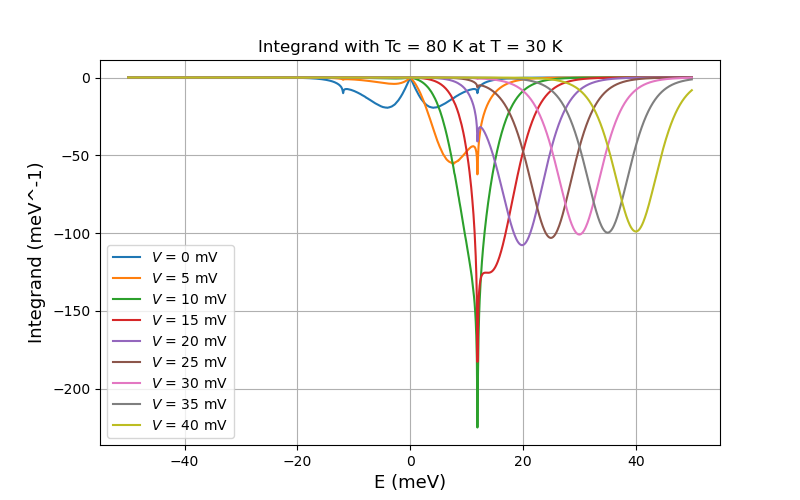

In [304]:
Vs = np.arange(0,41,5)
Tmp = 30
fig, ax = plt.subplots(figsize = (8,5))
for V in Vs:
    ax.plot(Evs, tun_intgd_d(Evs, V, Tmp), label = '$V$ = ' + str (V) + ' mV')
ax.set_title('Integrand with Tc = ' + str(Tc) + ' K at T = ' + str(Tmp) + ' K')
ax.set_xlabel('E (meV)', fontsize = 13)
ax.set_ylabel('Integrand (meV^-1)', fontsize = 13)
# ax.set_ylim(0,5)
ax.legend()
ax.grid()
plt.show()

#### Tunnelling Conductance d-wave

In [311]:
print('Computing tunnelling conductance for the d-wave superconductor proved to be very demanding computationally and demanded a lot more time for calculating than I had at my disposal. The functions defined above should, in theory, compute the tunnelling conductance for multiple temperatures and voltages (code below), but because of the double integral involved and the steps required for it to give a smooth curve it was not possible to put them to the test. However, their structure is similar to that in part 1 b) and each component subfunction works as expected, so I dare to affirm that the functions should work as desired given enough time. For these reasons, I will have to argue my deductions verbally. In the graph below, we can see how the integrand varies with voltage. I can thus predict that, similar to the case in 1 b), the tunnelling conductance should have a minimum at abs(V) = 0, should have a broad smooth peak as abs(V) increase from 0 and should then tend to a constant (1). The main difference with the s-wave, which should be most notable when T is small as ndash tends to a large value near E = 0, is the shape of the gap which for the s-wave should be flatter and step-like while for the d-wave it will look like the DoS above. Given the lack of graphs of the tunnelling conductance for the d-wave I refer you to the integrand plots at low temperature and different voltages for both types of superconductors (below) which illustrate my argument.')  

Computing tunnelling conductance for the d-wave superconductor proved to be very demanding computationally and demanded a lot more time for calculating than I had at my disposal. The functions defined above should, in theory, compute the tunnelling conductance for multiple temperatures and voltages (code below), but because of the double integral involved and the steps required for it to give a smooth curve it was not possible to put them to the test. However, their structure is similar to that in part 1 b) and each component subfunction works as expected, so I dare to affirm that the functions should work as desired given enough time. For these reasons, I will have to argue my deductions verbally. In the graph below, we can see how the integrand varies with voltage. I can thus predict that, similar to the case in 1 b), the tunnelling conductance should have a minimum at abs(V) = 0, should have a broad smooth peak as abs(V) increase from 0 and should then tend to a constant (1). The ma

In [ ]:
Vvals = np.arange(0,40+1,1)           # mV
Ts = np.arange(10,86,5)
fig, ax = plt.subplots(figsize = (12,6))
for T in Ts:
    g_array = []
    for V in Vvals:
        g1 = gd(V,T)
        g_array = np.append(g_array, g1)
    ax.plot(Vvals, g_array, label = '$T$ = ' + str(T) + ' K')
ax.set_title('Tunneling Conductance for Superconductor with $T_c$ = ' + str(Tc) + ' K', fontsize = 15)
ax.set_xlabel('$V$ (meV)', fontsize = 14)
ax.set_ylabel('$g(V,T)$',  fontsize = 14)
ax.tick_params(labelsize = 14)
ax.grid()
ax.legend(loc = 'center right')
plt.show()

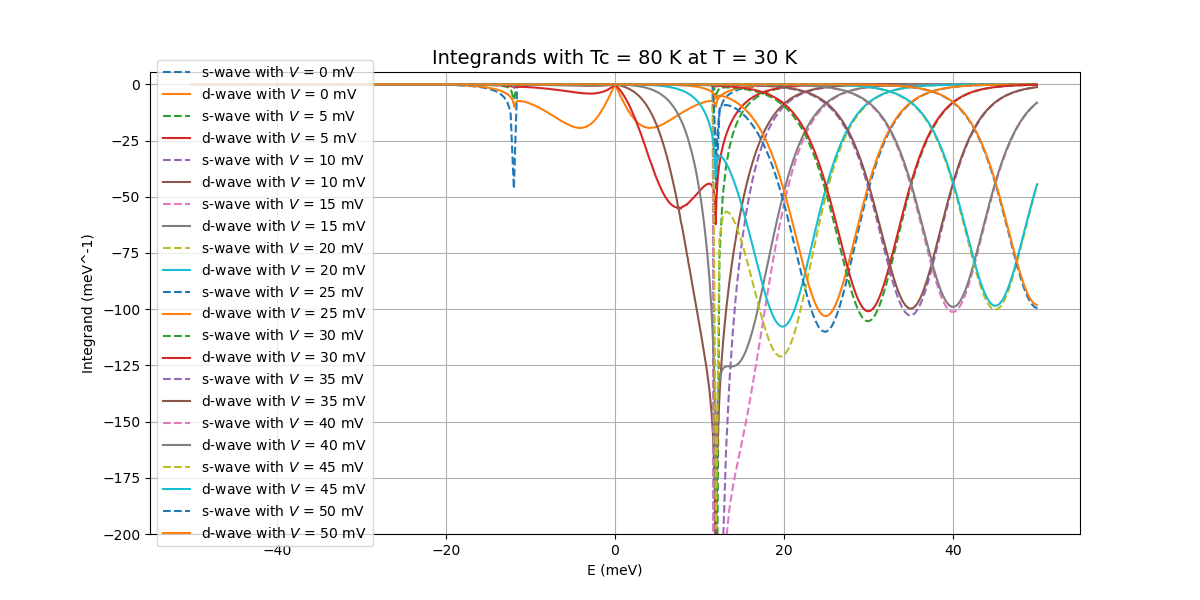

In [312]:
Vs = np.arange(0,51,5)
Tv = 30
fig, ax = plt.subplots(figsize = (12,6))

for V in Vs:
    ax.plot(Evals, tun_intgd_s(Evals, V, Tv), ls = '--', label = 's-wave with $V$ = ' + str(V) + ' mV')
    ax.plot(Evs, tun_intgd_d(Evs, V, Tv), label = 'd-wave with $V$ = ' + str (V) + ' mV')
ax.set_title('Integrands with Tc = ' + str(Tc) + ' K at T = ' + str(Tv) + ' K', fontsize = 14)
ax.set_xlabel('E (meV)')
ax.set_ylabel('Integrand (meV^-1)')
ax.set_ylim(-200, 5.5)
ax.grid()
ax.legend(loc = 'center left')
plt.show()